In [17]:
import numpy as np
import pandas as pd
import pyspark
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, count

spark = SparkSession.builder.appName("CarDatasetAnalysis").getOrCreate()

df = spark.read.csv("car_price_dataset.csv", header=True, inferSchema=True)

df.show(5)

# Data retrieved from
#https://www.kaggle.com/datasets/asinow/car-price-dataset?resource=download

+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|     Brand| Model|Year|Engine_Size|Fuel_Type|  Transmission|Mileage|Doors|Owner_Count|Price|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
|       Kia|   Rio|2020|        4.2|   Diesel|        Manual| 289944|    3|          5| 8501|
| Chevrolet|Malibu|2012|        2.0|   Hybrid|     Automatic|   5356|    2|          3|12092|
|  Mercedes|   GLA|2020|        4.2|   Diesel|     Automatic| 231440|    4|          2|11171|
|      Audi|    Q5|2023|        2.0| Electric|        Manual| 160971|    2|          1|11780|
|Volkswagen|  Golf|2003|        2.6|   Hybrid|Semi-Automatic| 286618|    3|          3| 2867|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-----+
only showing top 5 rows



In [19]:
df.describe().show()  

+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|summary|     Brand|   Model|             Year|       Engine_Size|Fuel_Type|  Transmission|          Mileage|            Doors|       Owner_Count|             Price|
+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|  count|     10000|   10000|            10000|             10000|    10000|         10000|            10000|            10000|             10000|             10000|
|   mean|      NULL|    NULL|        2011.5437|3.0005599999999966|     NULL|          NULL|      149239.1118|           3.4971|            2.9911|         8852.9644|
| stddev|      NULL|    NULL|6.897698756455926|1.1493240539456635|     NULL|          NULL|86322.34895733812|1.110096762215867|1.4226816904421142|3112.5968102892775|
|   

In [20]:
null_counts = []
for column in df.columns:
    count = df.filter(col(column).isNull()).count()
    null_counts.append((column, count))

null_df = spark.createDataFrame(null_counts, ["Column", "NULL_Count"])
null_df.show()

+------------+----------+
|      Column|NULL_Count|
+------------+----------+
|       Brand|         0|
|       Model|         0|
|        Year|         0|
| Engine_Size|         0|
|   Fuel_Type|         0|
|Transmission|         0|
|     Mileage|         0|
|       Doors|         0|
| Owner_Count|         0|
|       Price|         0|
+------------+----------+



In [21]:
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Duplicate Rows: {duplicate_count}")

Duplicate Rows: 0


In [22]:
df.select(
    col("price"),
    col("mileage"),
    col("year"),
    col("engine_size")
).describe().show()

+-------+------------------+-----------------+-----------------+------------------+
|summary|             price|          mileage|             year|       engine_size|
+-------+------------------+-----------------+-----------------+------------------+
|  count|             10000|            10000|            10000|             10000|
|   mean|         8852.9644|      149239.1118|        2011.5437|3.0005599999999966|
| stddev|3112.5968102892775|86322.34895733812|6.897698756455926|1.1493240539456635|
|    min|              2000|               25|             2000|               1.0|
|    max|             18301|           299947|             2023|               5.0|
+-------+------------------+-----------------+-----------------+------------------+



In [23]:
df.select("fuel_type").distinct().show()
df.select("transmission").distinct().show()
df.select("brand").distinct().show()

+---------+
|fuel_type|
+---------+
|   Diesel|
|   Hybrid|
| Electric|
|   Petrol|
+---------+

+--------------+
|  transmission|
+--------------+
|     Automatic|
|        Manual|
|Semi-Automatic|
+--------------+

+----------+
|     brand|
+----------+
|Volkswagen|
|       Kia|
| Chevrolet|
|   Hyundai|
|     Honda|
|      Audi|
|  Mercedes|
|       BMW|
|    Toyota|
|      Ford|
+----------+



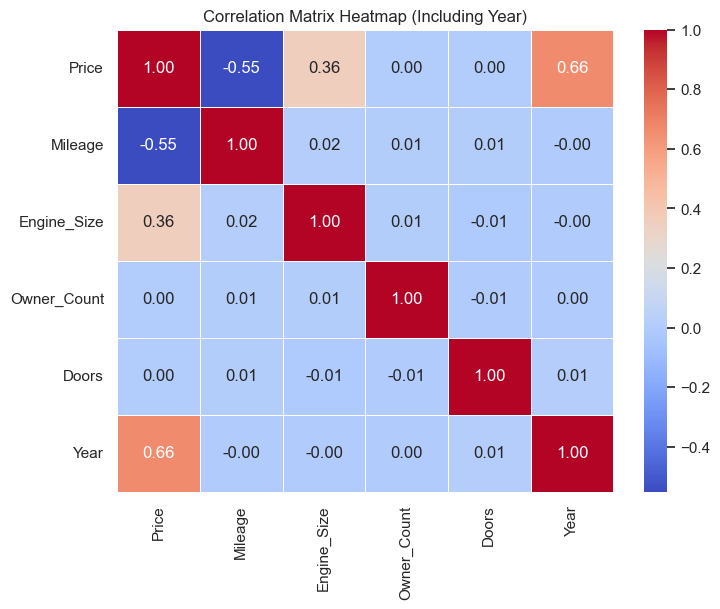

In [25]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

vector_col = "features"
assembler = VectorAssembler(inputCols=["Price", "Mileage", "Engine_Size", "Owner_Count", "Doors", "Year"], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Convert to NumPy array
corr_array = correlation_matrix.toArray()

columns = ["Price", "Mileage", "Engine_Size", "Owner_Count", "Doors", "Year"]

df_corr = pd.DataFrame(corr_array, columns=columns, index=columns)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap (Including Year)")
plt.show()


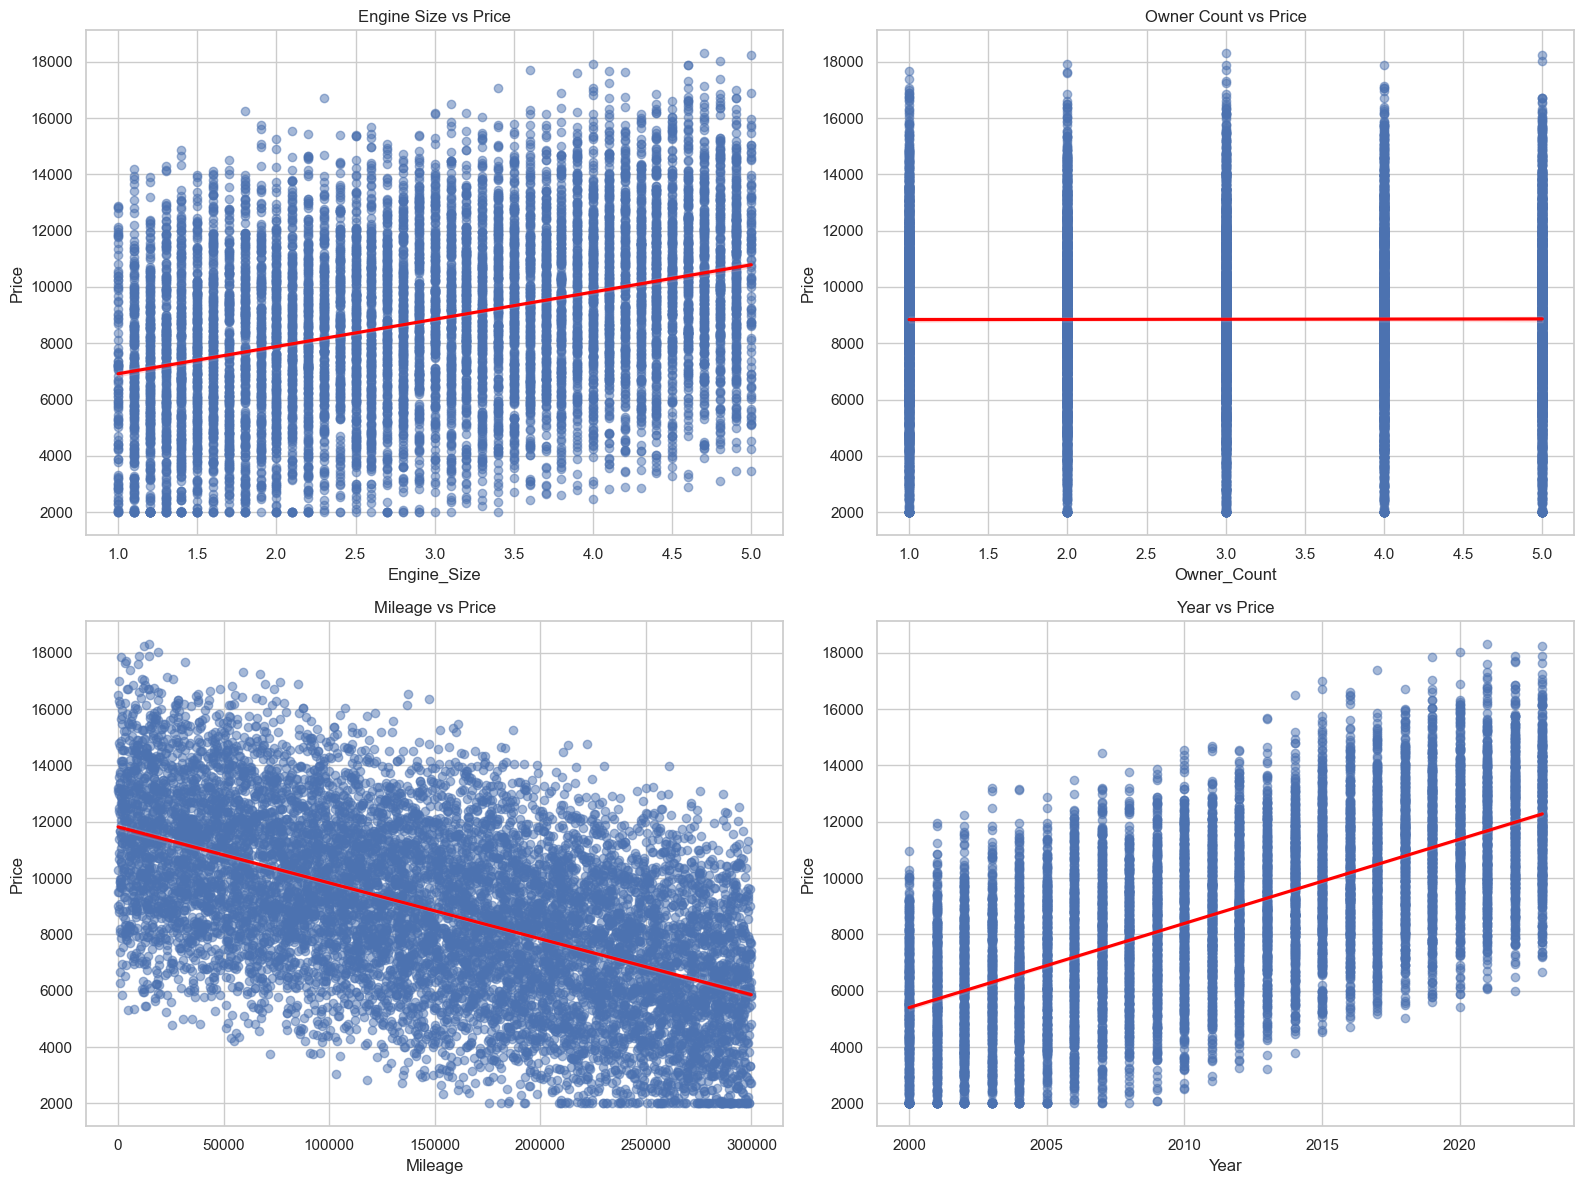

In [ ]:
# Convert PySpark DataFrame to Pandas for visualization
df_pandas = df.select("Price", "Engine_Size", "Owner_Count", "Mileage", "Year").toPandas()

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Engine Size vs Price
sns.regplot(x="Engine_Size", y="Price", data=df_pandas, ax=axes[0, 0], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[0, 0].set_title("Engine Size vs Price")

# Owner Count vs Price
sns.regplot(x="Owner_Count", y="Price", data=df_pandas, ax=axes[0, 1], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[0, 1].set_title("Owner Count vs Price")

# Mileage vs Price
sns.regplot(x="Mileage", y="Price", data=df_pandas, ax=axes[1, 0], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[1, 0].set_title("Mileage vs Price")

# Year vs Price 
sns.regplot(x="Year", y="Price", data=df_pandas, ax=axes[1, 1], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
axes[1, 1].set_title("Year vs Price")

plt.tight_layout()
plt.show()


#This corroborates what the heatmap suggests. Year, Mileage, and Engine_Size have fairly strong relationships with price
#While Owner_Count doesn't seem to have much of a relationship with price

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession

numerical_cols = ["Engine_Size", "Mileage", "Doors", "Owner_Count","Year"]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_numeric_transformed = assembler.transform(df).select("features", "Price")



train_data, test_data = df_numeric_transformed.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="Price", regParam=0.1)
numerical_lr_model = lr.fit(train_data)

numerical_test_results = numerical_lr_model.evaluate(test_data)

print("R² Score:", numerical_test_results.r2)
print("RMSE:", numerical_test_results.rootMeanSquaredError)


R² Score: 0.8759186801820145
RMSE: 1101.6527874502779


In [ ]:
from pyspark.sql import Row

user_input = [Row(Engine_Size=1.8, Mileage=90000, Doors=4, Owner_Count=3, Price=0, Year=2021)]  # Dummy Price

user_df = spark.createDataFrame(user_input)

user_transformed = assembler.transform(user_df).select("features", "Price")

user_prediction = numerical_lr_model.transform(user_transformed)
print("Numerical Model's prediction for this car")
user_prediction.select("prediction").show()

Numerical Model's prediction for this car
+------------------+
|        prediction|
+------------------+
|11678.017595491256|
+------------------+



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression

numerical_cols = ["Engine_Size", "Mileage", "Doors", "Owner_Count","Year"]
categorical_cols = ["Brand", "Model", "Fuel_Type", "Transmission"]

training_df = df

#Converting categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "Index", handleInvalid="keep").fit(training_df) 
            for col in categorical_cols]

for indexer in indexers:
    training_df = indexer.transform(training_df)

encoders = [OneHotEncoder(inputCol=col + "Index", outputCol=col + "Vec", dropLast=False) 
            for col in categorical_cols]

for encoder in encoders:
    training_df = encoder.fit(training_df).transform(training_df)


# Assemble numerical columns into a vector
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
training_df = assembler_numerical.transform(training_df)



# Create a final vector containing both categorical and numerical features
feature_cols = [col + "Vec" for col in categorical_cols] + ["numerical_features"]

assembler_all = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler_all.transform(training_df).select("features", "Price")


df_final.show(5, truncate=False)



+------------------------------------------------------------------------------+-----+
|features                                                                      |Price|
+------------------------------------------------------------------------------+-----+
|(56,[7,29,43,47,51,52,53,54,55],[1.0,1.0,1.0,1.0,4.2,289944.0,3.0,5.0,2020.0])|8501 |
|(56,[4,26,44,48,51,52,53,54,55],[1.0,1.0,1.0,1.0,2.0,5356.0,2.0,3.0,2012.0])  |12092|
|(56,[9,36,43,48,51,52,53,54,55],[1.0,1.0,1.0,1.0,4.2,231440.0,4.0,2.0,2020.0])|11171|
|(56,[1,18,42,47,51,52,53,54,55],[1.0,1.0,1.0,1.0,2.0,160971.0,2.0,1.0,2023.0])|11780|
|(56,[2,20,44,49,51,52,53,54,55],[1.0,1.0,1.0,1.0,2.6,286618.0,3.0,3.0,2003.0])|2867 |
+------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [ ]:
# Split Data into Training and Testing Sets
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Initialize & Train the Model
lr = LinearRegression(featuresCol="features", labelCol="Price", regParam=0.1)
full_lr_model = lr.fit(train_data)

# Evaluate Model
full_test_results = full_lr_model.evaluate(test_data)

print("R² Score:", full_test_results.r2)
print("RMSE:", full_test_results.rootMeanSquaredError)


R² Score: 0.9998324518258466
RMSE: 39.496328398056136


In [ ]:
df.show(1)

+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|Brand|Model|Year|Engine_Size|Fuel_Type|Transmission|Mileage|Doors|Owner_Count|Price|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|  Kia|  Rio|2020|        4.2|   Diesel|      Manual| 289944|    3|          5| 8501|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
only showing top 1 row



In [ ]:
def make_prediction_for_car(user_input, indexers=indexers, encoders=encoders, categorical_cols=["Brand", "Model", "Fuel_Type", "Transmission"], numerical_cols = ["Engine_Size", "Mileage", "Doors", "Owner_Count","Year"]):
    this_car_df = spark.createDataFrame(user_input)
    for indexer in indexers:
        this_car_df = indexer.transform(this_car_df)

    for encoder in encoders:
        this_car_df = encoder.fit(this_car_df).transform(this_car_df)

    assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
    this_car_df = assembler_numerical.transform(this_car_df)

    feature_cols = [col + "Vec" for col in categorical_cols] + ["numerical_features"]
    assembler_all = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_final = assembler_all.transform(this_car_df).select("features", "Price")

    this_car_prediction = full_lr_model.transform(df_final)


    print("Full Model's prediction for this car")
    this_car_prediction.select("prediction").show()




In [ ]:

my_car = [Row(Brand="Nissan",Model="Versa",Year=2021,Engine_Size=1.8,Fuel_Type="Petrol",Transmission="Automatic",Mileage=90000,Doors=4,Owner_Count=3,Price=0)]  # Dummy Price

make_prediction_for_car(my_car)



Full Model's prediction for this car
+------------------+
|        prediction|
+------------------+
|11895.097291065496|
+------------------+

